## Understanding Fat Tails

### Background

Observed 99% loss = -4%, Normal distribution predicts 99% loss = -2.3%

This indicates that the actual distribution has **fatter tails** than a normal distribution.

### Explanation (Two Perspectives)

1. If the realized 99% loss is much larger than what a normal model predicts, it means extreme losses occur more often than a Gaussian would allow.

2. Under a normal distribution, if −2.3% is the 99% loss, the implied σ is roughly **1%**. A −4% loss would then be a **4σ event**. In a normal distribution, a 4-sigma move has probability around **0.003%**, much smaller then **1%**.

---

### Key Findings Summary

**VaR and Expected Shortfall (99% confidence level):**
- **Empirical**: VaR = -3.42%, ES = -4.92%
- **Normal Model**: VaR = -2.81%, ES = -3.22% (underestimates risk)
- **Student-t Model**: VaR = -3.49%, ES = -5.78% (best fit for ES)

**Key Insight**: The Normal distribution significantly underestimates tail risk:
- VaR gap: -0.62% (Normal underestimates by 0.62%)
- ES gap: -1.70% (Normal underestimates by 1.70%)

**Distribution Fitting Results:**
- **Student-t** (df = 2.65): Best overall fit (lowest AIC: -41,005.64)
- **Generalized Normal** (β = 0.87): Second best (AIC: -41,003.85)
- **Normal**: Poor fit (AIC: -39,102.22, KS p-value = 0.0000)

**Conclusion**: SPX returns exhibit **fat tails** that are better captured by Student-t or Generalized Normal distributions. The Normal distribution fails to adequately model extreme losses.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
spx = yf.download("^GSPC", start="2000-01-01")
returns_pd = spx["Close"].pct_change().dropna()

# Convert to numpy array once
returns = np.asarray(returns_pd)
returns = np.squeeze(returns)
if returns.ndim != 1:
    raise ValueError(f"Expected 1D returns, got shape {returns.shape}")
returns = returns[~np.isnan(returns)]


[*********************100%***********************]  1 of 1 completed


In [3]:
# 99% VaR / ES (empirical vs Normal vs Student-t)
from scipy.stats import norm, t

alpha = 0.99

def empirical_var_es(returns: np.ndarray, alpha: float):
    """Historical VaR/ES"""
    p = 1 - float(alpha)
    var = float(np.quantile(returns, p))
    es = float(returns[returns <= var].mean())
    return var, es


def normal_var_es(returns: np.ndarray, alpha: float):
    """Normal VaR/ES"""
    p = 1 - float(alpha)
    mu = float(returns.mean())
    sigma = float(returns.std(ddof=1))
    z = float(norm.ppf(p))
    var = mu + z * sigma
    es = mu - sigma * (norm.pdf(z) / p)
    return var, es


def student_t_var_es(returns: np.ndarray, alpha: float):
    """Student-t VaR/ES"""
    p = 1 - float(alpha)
    df, loc, scale = t.fit(returns)
    q = float(t.ppf(p, df))
    var = float(loc + scale * q)
    es = float(loc - scale * (t.pdf(q, df) * (df + q**2) / ((df - 1) * p)))

    return var, es, float(df)

var_emp, es_emp = empirical_var_es(returns, alpha)
var_norm, es_norm = normal_var_es(returns, alpha)
var_t, es_t, df_t = student_t_var_es(returns, alpha)


# Create results table
results_data = {
    'Method': ['Empirical', 'Empirical', 'Normal', 'Normal', 'Student-t', 'Student-t'],
    'Metric': ['VaR 99%', 'ES 99%', 'VaR 99%', 'ES 99%', 'VaR 99%', 'ES 99%'],
    'Value (%)': [var_emp * 100, es_emp * 100, var_norm * 100, es_norm * 100, var_t * 100, es_t * 100]
}
results_df = pd.DataFrame(results_data)
results_df['Value (%)'] = results_df['Value (%)'].apply(lambda x: f"{x:.4f}%")

print("VaR and ES Results:")
print(results_df.to_string(index=False))
print()

# Create gaps table
gaps_data = {
    'Comparison': ['Empirical - Normal', 'Empirical - Normal', 'Empirical - Student-t', 'Empirical - Student-t'],
    'Metric': ['VaR', 'ES', 'VaR', 'ES'],
    'Gap (%)': [(var_emp - var_norm) * 100, (es_emp - es_norm) * 100, 
                (var_emp - var_t) * 100, (es_emp - es_t) * 100]
}
gaps_df = pd.DataFrame(gaps_data)
gaps_df['Gap (%)'] = gaps_df['Gap (%)'].apply(lambda x: f"{x:.4f}%")

print("Gaps (Empirical vs Models):")
print(gaps_df.to_string(index=False))
print()
print(f"Student-t degrees of freedom: {df_t:.2f}")


VaR and ES Results:
   Method  Metric Value (%)
Empirical VaR 99%  -3.4228%
Empirical  ES 99%  -4.9186%
   Normal VaR 99%  -2.8054%
   Normal  ES 99%  -3.2186%
Student-t VaR 99%  -3.4929%
Student-t  ES 99%  -5.7764%

Gaps (Empirical vs Models):
           Comparison Metric  Gap (%)
   Empirical - Normal    VaR -0.6174%
   Empirical - Normal     ES -1.7000%
Empirical - Student-t    VaR  0.0701%
Empirical - Student-t     ES  0.8578%

Student-t degrees of freedom: 2.65


In [4]:
# Fit multiple distributions to the returns
from scipy.stats import norm, t, gennorm

# Fit distributions
fits = {}

# Normal distribution
mu_norm, sigma_norm = norm.fit(returns)
fits['Normal'] = {'params': (mu_norm, sigma_norm), 'dist': norm}

# Student-t distribution
df_t, loc_t, scale_t = t.fit(returns)
fits['Student-t'] = {'params': (df_t, loc_t, scale_t), 'dist': t}

# Generalized Normal (Subbotin) distribution
beta_gnorm, loc_gnorm, scale_gnorm = gennorm.fit(returns)
fits['Generalized Normal'] = {'params': (beta_gnorm, loc_gnorm, scale_gnorm), 'dist': gennorm}

# Print fitted parameters
print("Fitted Distribution Parameters:")
print("=" * 60)
for name, fit_info in fits.items():
    params = fit_info['params']
    print(f"\n{name}:")
    if name == 'Normal':
        print(f"  μ (mean): {params[0]:.6f}")
        print(f"  σ (std): {params[1]:.6f}")
    elif name == 'Student-t':
        print(f"  df (degrees of freedom): {params[0]:.2f}")
        print(f"  loc: {params[1]:.6f}")
        print(f"  scale: {params[2]:.6f}")
    elif name == 'Generalized Normal':
        print(f"  β (shape): {params[0]:.2f}")
        print(f"  loc: {params[1]:.6f}")
        print(f"  scale: {params[2]:.6f}")

Fitted Distribution Parameters:

Normal:
  μ (mean): 0.000314
  σ (std): 0.012193

Student-t:
  df (degrees of freedom): 2.65
  loc: 0.000681
  scale: 0.007040

Generalized Normal:
  β (shape): 0.87
  loc: 0.000688
  scale: 0.006493


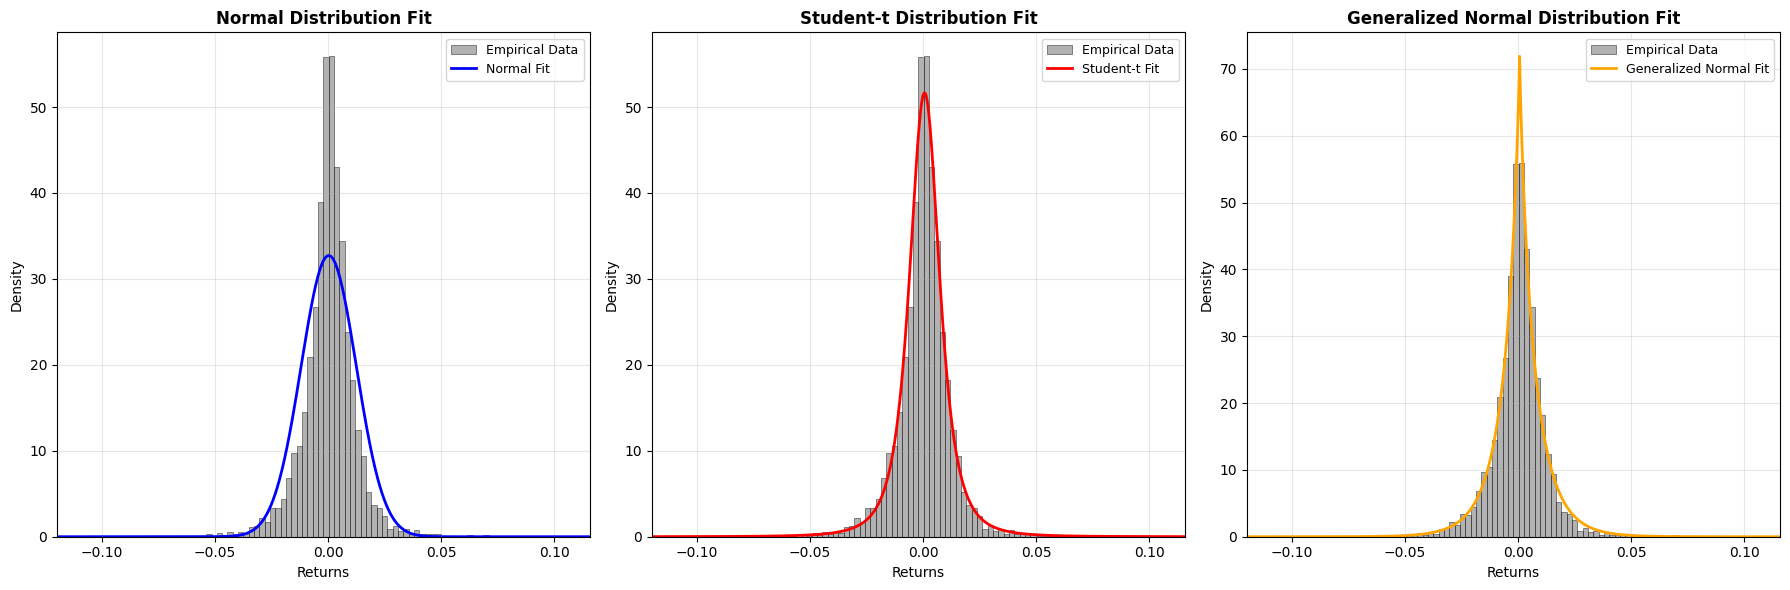

In [5]:
# Plot 1: Histogram with fitted PDFs overlaid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

# Create x values for PDF plotting
x = np.linspace(returns.min(), returns.max(), 1000)

# Colors for each distribution
colors = {
    'Normal': 'blue',
    'Student-t': 'red',
    'Generalized Normal': 'orange'
}

for idx, (name, fit_info) in enumerate(fits.items()):
    ax = axes[idx]
    
    # Plot histogram of empirical data
    ax.hist(returns, bins=100, density=True, alpha=0.6, color='gray', 
            label='Empirical Data', edgecolor='black', linewidth=0.5)
    
    # Plot fitted PDF
    params = fit_info['params']
    dist = fit_info['dist']
    
    if name == 'Normal':
        pdf = dist.pdf(x, *params)
    elif name == 'Student-t':
        pdf = dist.pdf(x, *params)
    elif name == 'Generalized Normal':
        pdf = dist.pdf(x, *params)
    else:
        pdf = dist.pdf(x, *params)
    
    ax.plot(x, pdf, color=colors[name], linewidth=2, label=f'{name} Fit')
    
    ax.set_title(f'{name} Distribution Fit', fontsize=12, fontweight='bold')
    ax.set_xlabel('Returns', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(returns.min(), returns.max())

plt.tight_layout()
plt.show()

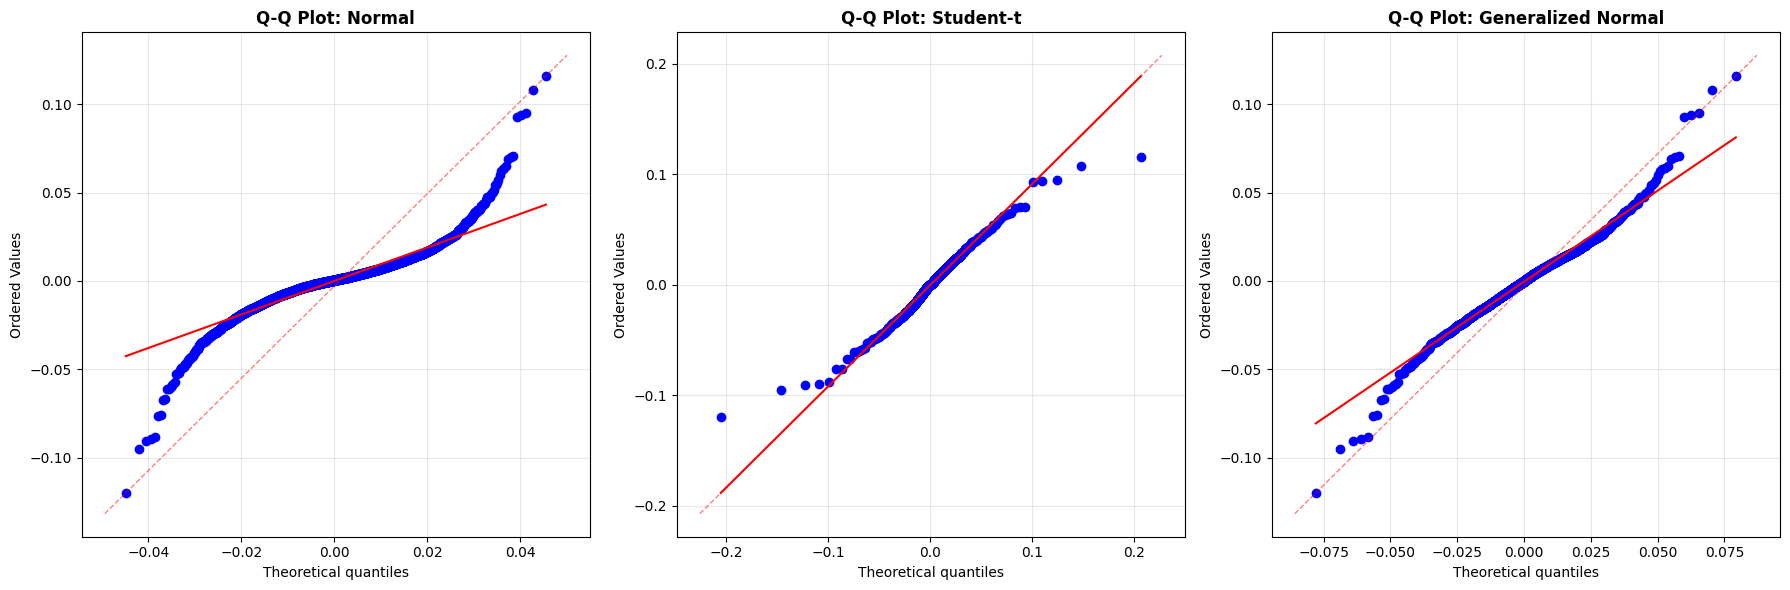

In [6]:
# Plot 2: Q-Q plots for each distribution
from scipy.stats import probplot

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for idx, (name, fit_info) in enumerate(fits.items()):
    ax = axes[idx]
    
    params = fit_info['params']
    dist = fit_info['dist']
    
    # Create Q-Q plot
    if name == 'Normal':
        probplot(returns, dist=dist, sparams=params, plot=ax)
    elif name == 'Student-t':
        probplot(returns, dist=dist, sparams=params, plot=ax)
    elif name == 'Generalized Normal':
        probplot(returns, dist=dist, sparams=params, plot=ax)
    else:
        probplot(returns, dist=dist, sparams=params, plot=ax)
    
    ax.set_title(f'Q-Q Plot: {name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # Add diagonal reference line
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [7]:
# Calculate goodness of fit statistics (AIC, BIC, Log-Likelihood)
from scipy.stats import kstest

fit_stats = []

for name, fit_info in fits.items():
    params = fit_info['params']
    dist = fit_info['dist']
    
    # Calculate log-likelihood
    if name == 'Normal':
        log_likelihood = np.sum(dist.logpdf(returns, *params))
        n_params = 2
    elif name == 'Student-t':
        log_likelihood = np.sum(dist.logpdf(returns, *params))
        n_params = 3
    elif name == 'Generalized Normal':
        log_likelihood = np.sum(dist.logpdf(returns, *params))
        n_params = 3
    else:
        raise ValueError(f"Unsupported distribution: {name}")
    
    # AIC = 2k - 2ln(L), BIC = k*ln(n) - 2ln(L)
    n = len(returns)
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n) - 2 * log_likelihood
    
    # Kolmogorov-Smirnov test
    if name == 'Normal':
        ks_stat, ks_pvalue = kstest(returns, lambda x: dist.cdf(x, *params))
    elif name == 'Student-t':
        ks_stat, ks_pvalue = kstest(returns, lambda x: dist.cdf(x, *params))
    elif name == 'Generalized Normal':
        ks_stat, ks_pvalue = kstest(returns, lambda x: dist.cdf(x, *params))
    else:
        raise ValueError(f"Unsupported distribution: {name}")
    
    fit_stats.append({
        'Distribution': name,
        'Log-Likelihood': log_likelihood,
        'AIC': aic,
        'BIC': bic,
        'KS Statistic': ks_stat,
        'KS p-value': ks_pvalue,
        'n_params': n_params
    })

stats_df = pd.DataFrame(fit_stats)
stats_df = stats_df.sort_values('AIC')

print("Goodness of Fit Statistics:")
print("=" * 80)
print(stats_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("\nNote: Lower AIC/BIC values indicate better fit.")
print("      Lower KS statistic and higher p-value indicate better fit.")

Goodness of Fit Statistics:
      Distribution  Log-Likelihood         AIC         BIC  KS Statistic  KS p-value  n_params
         Student-t      20505.8204 -41005.6408 -40985.2819        0.0176      0.0348         3
Generalized Normal      20504.9248 -41003.8497 -40983.4908        0.0179      0.0297         3
            Normal      19553.1086 -39102.2171 -39088.6445        0.0923      0.0000         2

Note: Lower AIC/BIC values indicate better fit.
      Lower KS statistic and higher p-value indicate better fit.
